In [1]:
import copy
import torch
from torch import nn
from torch import functional as F
from mnist import MNIST
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.preprocessing import scale
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score


Напишем свой батч генератор. 

In [2]:
def batch_generator(X, y, batch_size):
    np.random.seed(42)
    perm = np.random.permutation(len(X))
    cur_pos = 0;
    while(cur_pos < len(X)):
        yield X[perm[cur_pos:cur_pos+batch_size]], y[perm[cur_pos:cur_pos+batch_size]]
        cur_pos += batch_size

In [28]:
N = 1000
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

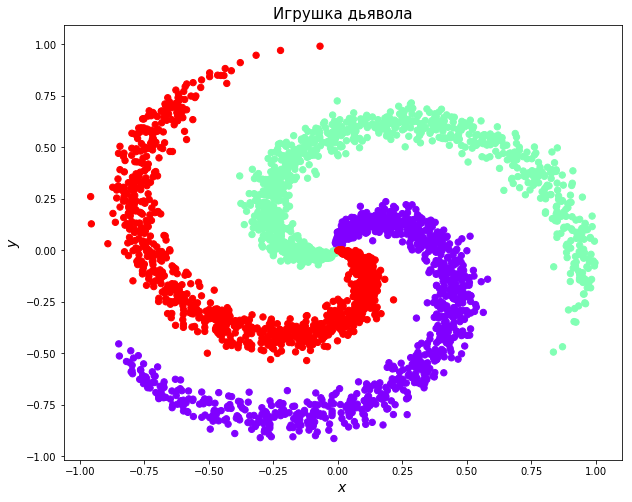

In [29]:
plt.figure(figsize=(10, 8))

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

Превратим данные в тензоры, чтобы потом было удобнее

In [31]:
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

print(X_test.shape, y_test.shape)
print(X_train.shape, y_train.shape)



torch.Size([900, 2]) torch.Size([900])
torch.Size([2100, 2]) torch.Size([2100])


In [132]:
def train(X_train, y_train, X_test, y_test, num_epoch, optimizer, loss_fn):
    train_losses = []
    train_accuracy = []
    test_losses = []
    test_accuracy = []
    for i in range(num_epoch):
        epoch_train_losses = []
        epoch_train_accuracy = []
        for X_batch, y_batch in batch_generator(X_train, y_train, 100):
            model.train(True)
            # Посчитаем предсказание и лосс
            y_predict = model.forward(X_batch)
            loss = loss_fn(y_predict, y_batch)
            
            # зануляем градиент
            optimizer.zero_grad()
            
            # backward
            loss.backward()
            
            # ОБНОВЛЯЕМ веса
            optimizer.step()
            
            # Запишем число (не тензор) в наши батчевые лоссы
            epoch_train_losses.append(loss.item())
            epoch_train_accuracy.append(accuracy_score(y_predict.max(1)[1], y_batch))
            
            
        train_losses.append(np.mean(epoch_train_losses))
        train_accuracy.append(np.mean(epoch_train_accuracy))
        
        # Теперь посчитаем лосс на тесте
        model.train(False)
        with torch.no_grad():
            y_predict_test = model.forward(X_test)
            test_loss = loss_fn(y_predict_test, y_test)
            test_losses.append(test_loss.item())
            test_accuracy.append(accuracy_score(y_predict_test.max(1)[1], y_test))
            
    return train_losses, test_losses, train_accuracy, test_accuracy

In [33]:
COUNT_EPOCH = 50
LOSS_FN = nn.CrossEntropyLoss()

In [34]:
input_size = int(X_train.shape[1])
output_size = len(np.unique(y_train))
print(input_size, output_size)

2 3


In [35]:
def get_model(input_size, output_size):
    return nn.Sequential(
        nn.Linear(input_size, 100),
        nn.ReLU(),
        #nn.BatchNorm1d(100),
        nn.Linear(100, 100),
        nn.ReLU(),
        #nn.BatchNorm1d(100),
        nn.Linear(100, 100),
        nn.ReLU(),
        #nn.BatchNorm1d(100),
        nn.Linear(100, output_size)
    )

ADAM

In [136]:
%%time

model = get_model(input_size, output_size)

adam_optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)

adam_train_losses, adam_test_losses, adam_train_accuracy, adam_test_accuracy = train(
    X_train, y_train, X_test, y_test, COUNT_EPOCH, adam_optimizer, LOSS_FN
)

CPU times: user 6.92 s, sys: 78.3 ms, total: 7 s
Wall time: 2.79 s


SGD

In [147]:
%%time

model = get_model(input_size, output_size)
 
sgd_optimizer = torch.optim.SGD(model.parameters(), lr=2e-1, momentum=0)

sgd_train_losses, sgd_test_losses, sgd_train_accuracy, sgd_test_accuracy = train(
    X_train, y_train, X_test, y_test, COUNT_EPOCH, sgd_optimizer, LOSS_FN
)

CPU times: user 5 s, sys: 53.8 ms, total: 5.06 s
Wall time: 1.93 s


Nesterov

In [138]:
%%time

model = get_model(input_size, output_size)

nesterov_optimizer = torch.optim.SGD(model.parameters(), lr=5e-2, momentum=0.9, nesterov=True)

nesterov_train_losses, nesterov_test_losses, nesterov_train_accuracy, nesterov_test_accuracy = train(
    X_train, y_train, X_test, y_test, COUNT_EPOCH, nesterov_optimizer, LOSS_FN
)


CPU times: user 5.09 s, sys: 30.1 ms, total: 5.12 s
Wall time: 1.78 s


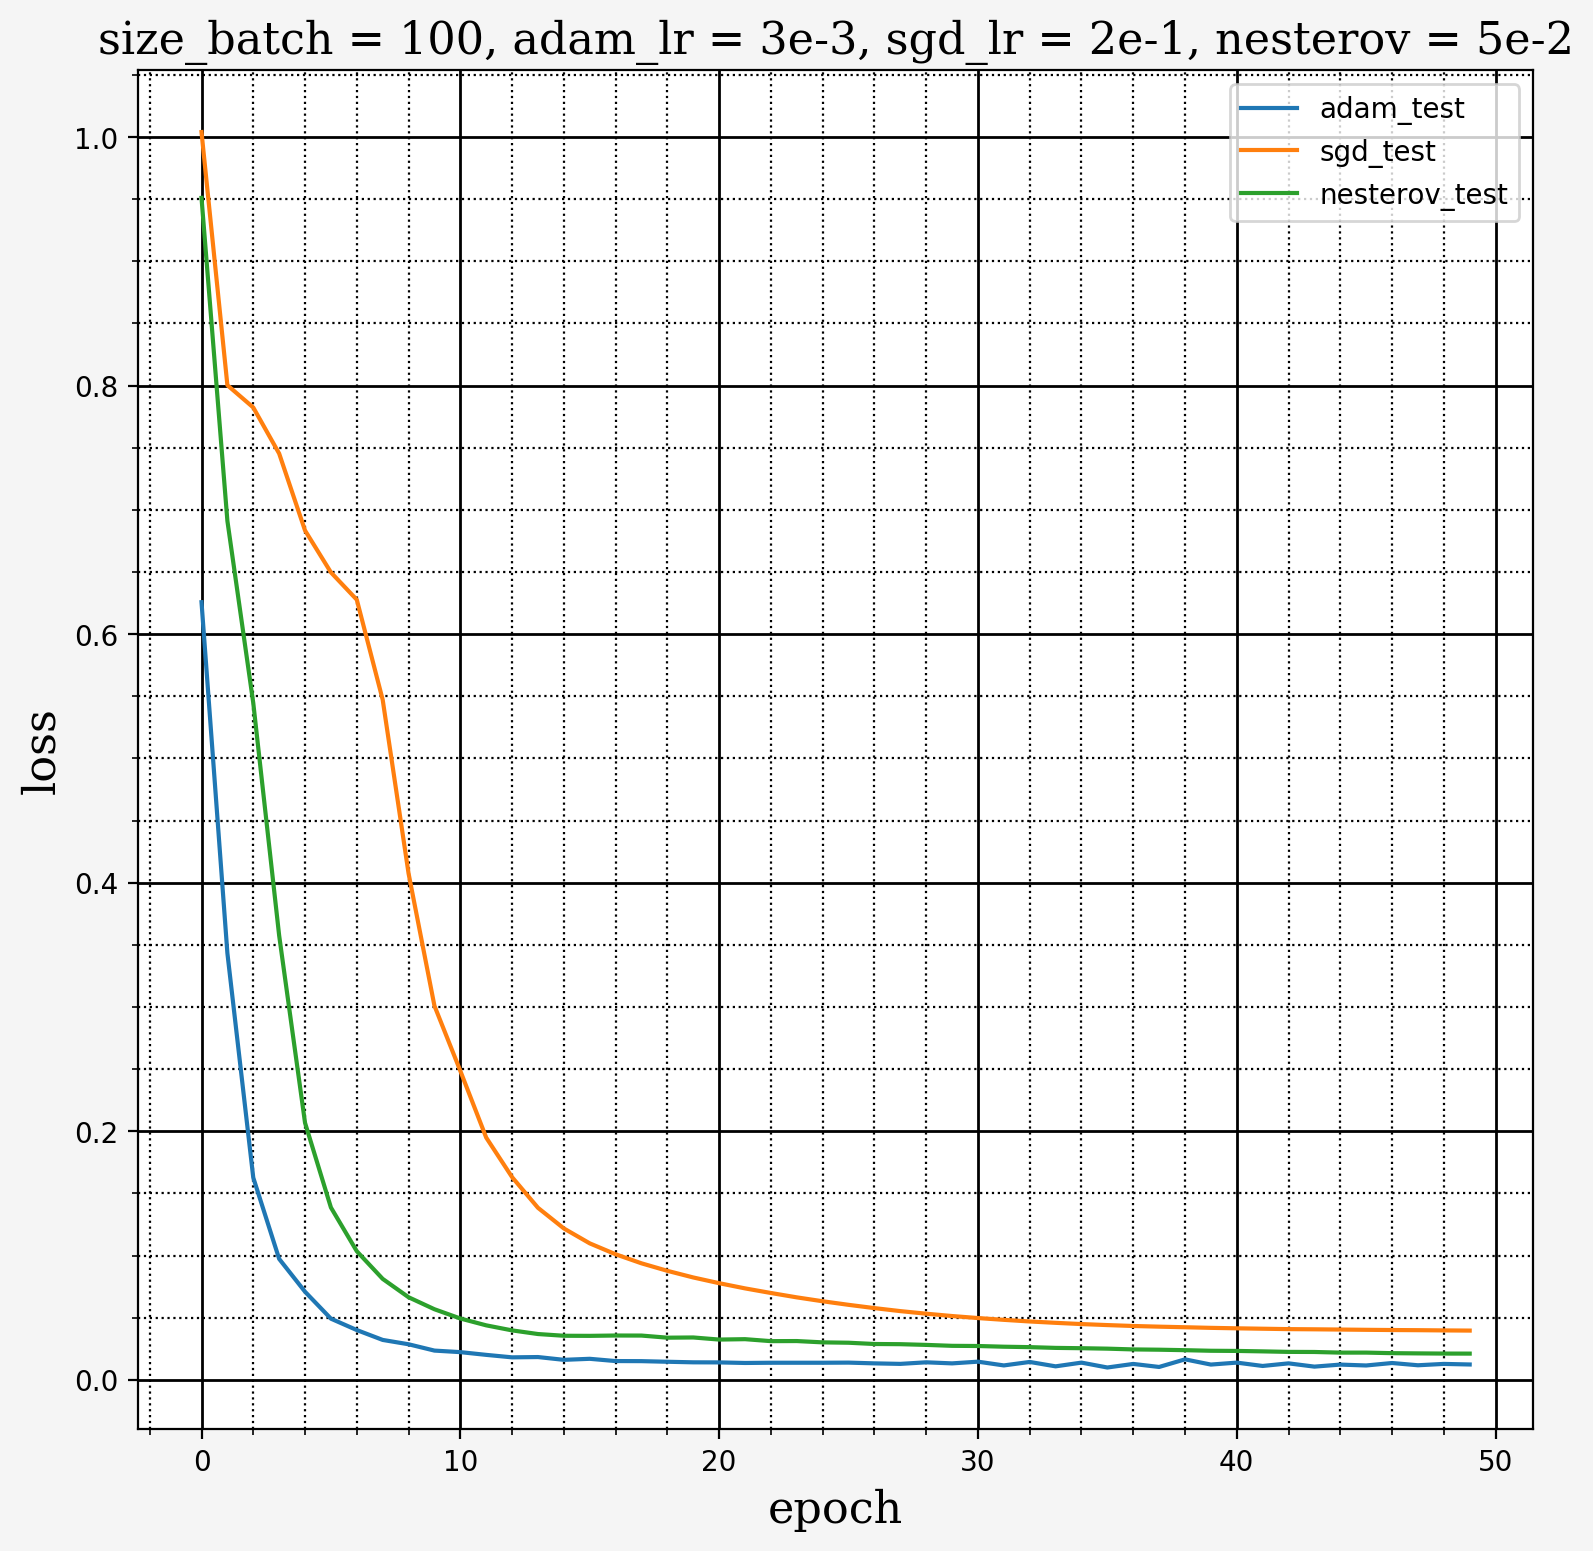

In [150]:
fig = plt.figure(
    figsize=(9,9),
    facecolor='whitesmoke',
    dpi=200
)
plt.minorticks_on()
#  Определяем внешний вид линий основной сетки:
plt.grid(which='major',
        color = 'k', 
        linewidth = 1)
#  Определяем внешний вид линий вспомогательной
#  сетки:
plt.grid(which='minor', 
        color = 'k', 
        linestyle = ':')

plt.title(
    'size_batch = 100, adam_lr = 3e-3, sgd_lr = 2e-1, nesterov = 5e-2',
    fontdict=dict(family='serif', color='black', weight='normal', size=16)    
)
plt.xlabel(
    'epoch',
    fontdict=dict(family='serif', color='black', weight='normal', size=16)
)
plt.ylabel(
    'loss',
    fontdict=dict(family='serif', color='black', weight='normal', size=16)
)

# plt.plot(
#     adam_train_losses, 
#     label='adam_train',
#     linestyle='--'
# )
plt.plot( 
    adam_test_losses, 
    label='adam_test'
)

# plt.plot(
#     sgd_train_losses, 
#     label='sgd_train',
#     linestyle='--'
# )
plt.plot( 
    sgd_test_losses, 
    label='sgd_test'
)

# plt.plot(
#     nesterov_train_losses, 
#     label='nesterov_train',
#     linestyle='--'
# )
plt.plot( 
    nesterov_test_losses, 
    label='nesterov_test'
)

plt.legend()
plt.show()

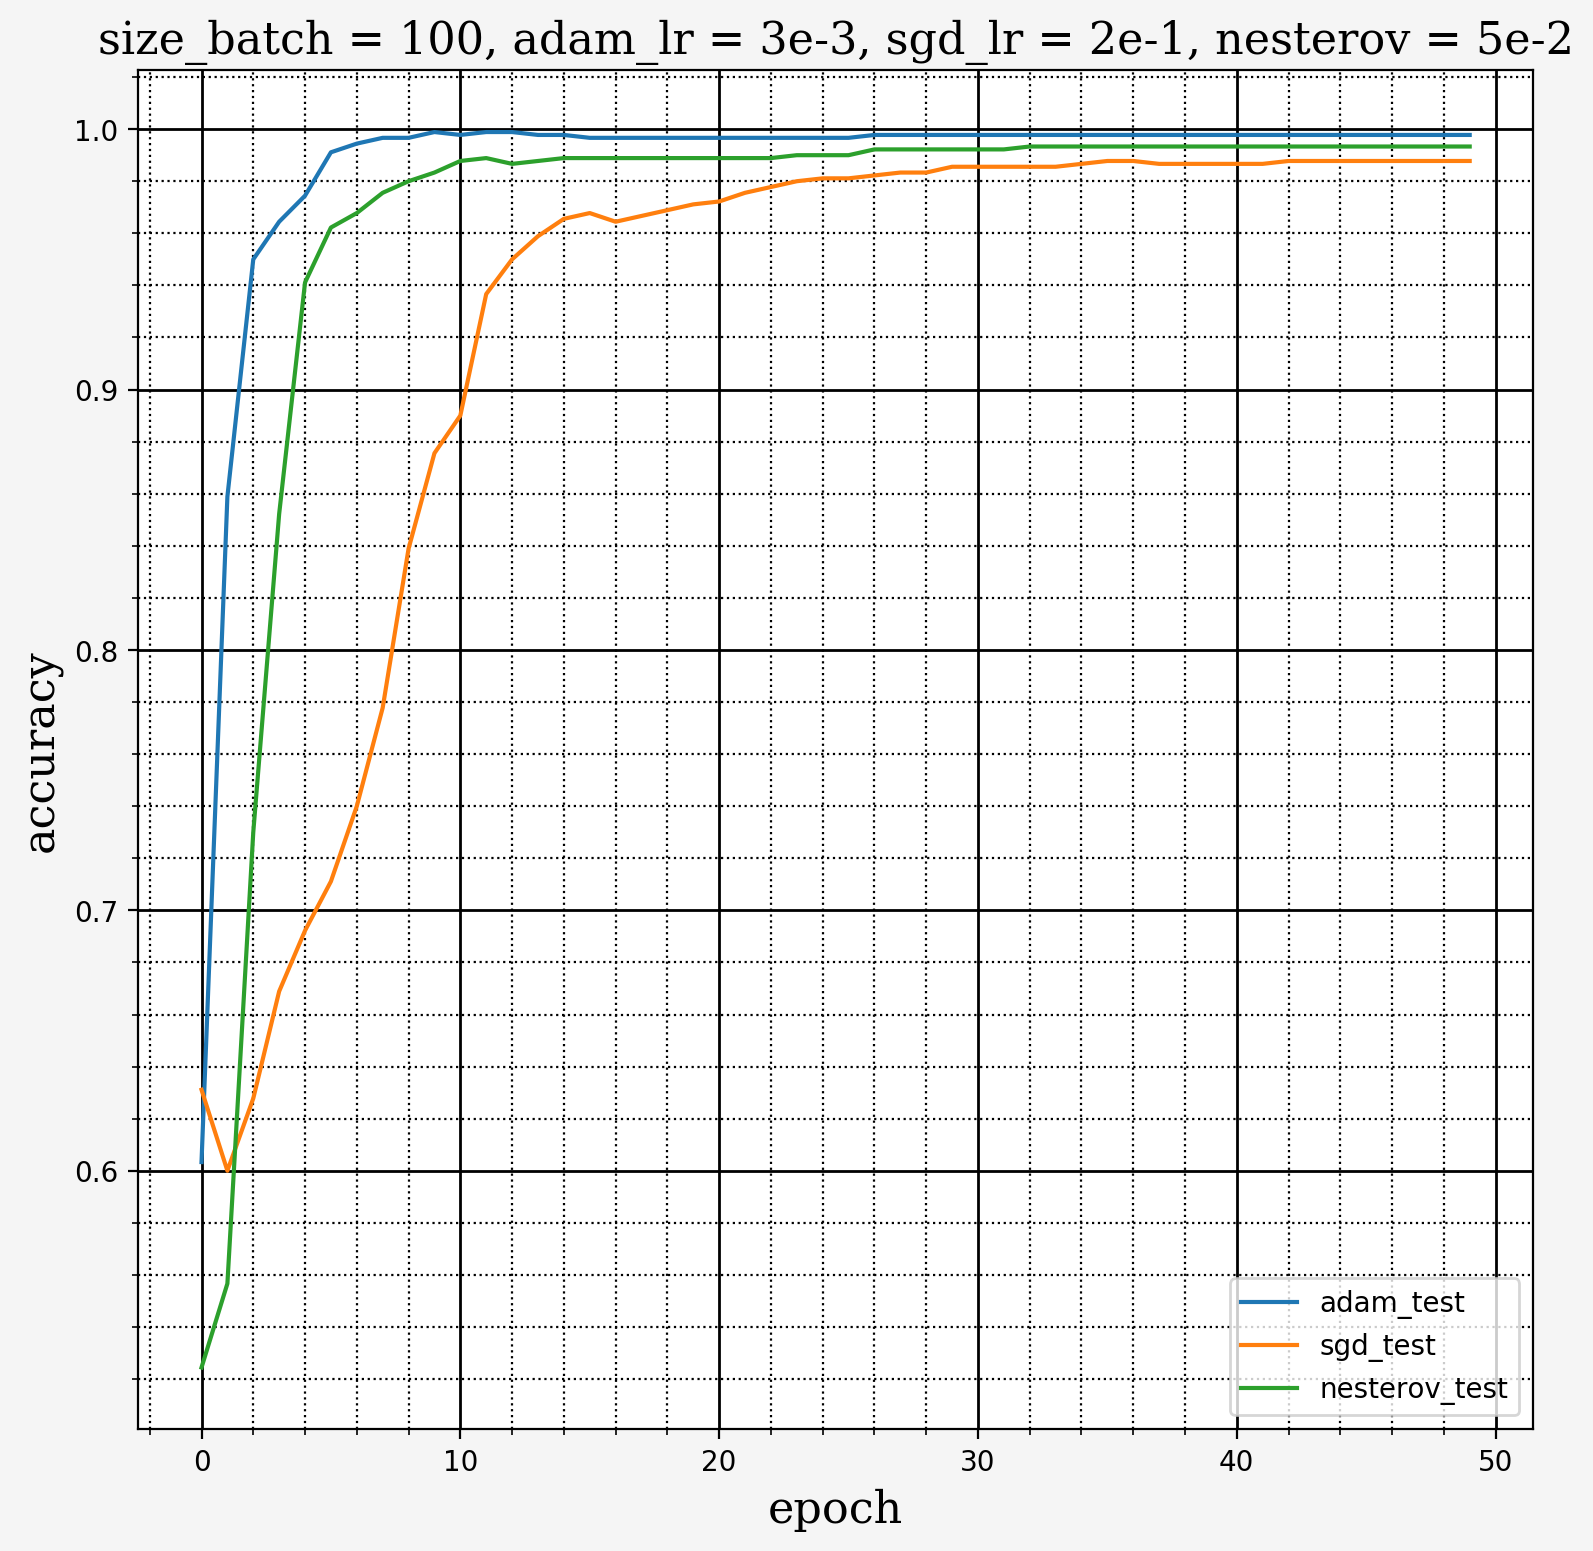

In [151]:
fig = plt.figure(
    figsize=(9,9),
    facecolor='whitesmoke',
    dpi=200
)
plt.minorticks_on()
#  Определяем внешний вид линий основной сетки:
plt.grid(which='major',
        color = 'k', 
        linewidth = 1)
#  Определяем внешний вид линий вспомогательной
#  сетки:
plt.grid(which='minor', 
        color = 'k', 
        linestyle = ':')

plt.title(
    'size_batch = 100, adam_lr = 3e-3, sgd_lr = 2e-1, nesterov = 5e-2',
    fontdict=dict(family='serif', color='black', weight='normal', size=16)    
)
plt.xlabel(
    'epoch',
    fontdict=dict(family='serif', color='black', weight='normal', size=16)
)
plt.ylabel(
    'accuracy',
    fontdict=dict(family='serif', color='black', weight='normal', size=16)
)

# plt.plot(
#     adam_train_accuracy, 
#     label='adam_train',
#     linestyle='--'
# )
plt.plot(
    adam_test_accuracy, 
    label='adam_test'
)

# plt.plot(
#     sgd_train_accuracy, 
#     label='sgd_train',
#     linestyle='--'
# )
plt.plot(
    sgd_test_accuracy, 
    label='sgd_test'
)

# plt.plot(
#     nesterov_train_accuracy, 
#     label='nesterov_train',
#     linestyle='--'
# )
plt.plot(
    nesterov_test_accuracy, 
    label='nesterov_test'
)

plt.legend()
plt.show()